# Quickstart Example with Synthetic Simulation (Customization)
This notebook provides an example of customizing the Recommender environment.

This example on the Synthetic Recommender Simulation consists of the following 3 steps:
1. Setup Synthetic Recommender Simulation Environment and Interacting Online RL Agent
2. Standardized Environment
3. Customize Environmental Configuration

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations.  

In [50]:
# delete later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [52]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [53]:
# import OFRL modules
import ofrl
from ofrl.policy import OnlineHead
from ofrl.policy import DiscreteEpsilonGreedyHead

# import synthetic modules
# import synthetic
from syntheticgym import SyntheticEnv
from syntheticgym import RewardFunction
from syntheticgym import StateTransition
from syntheticgym import BaseRewardFunction
from syntheticgym import BaseStateTransition

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import gym

from sklearn.utils import check_random_state
from sklearn.utils import check_scalar

In [54]:
from dataclasses import dataclass
from typing import Tuple, Union, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [55]:
# version
print(ofrl.__version__)

0.0.0


In [56]:
# set random state
random_state = 12345
random_ = check_random_state(random_state)

## 1. Setup Synthetic Recommender Simulation Environment and Interacting Online RL Agent
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for Recommendation
In recommendation, the objective of the RL agent is to maximize reward

We often formulate this recommendation problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: 
   - A vector representing user preference.  The preference changes over time in an episode by the actions presented by the RL agent.
   - When the true state is unobservable, you can gain observation instead of state.
- `action`:  Index of an item to present to the user.
- `reward`: User engagement signal. Either binary or continuous.

Let's see how it works!

In [57]:
# setup environment
env = SyntheticEnv(action_type='continuous', random_state=random_state)

In [58]:
# define a random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    ),
    name="random",
)
agent.build_with_env(env)

In [59]:
print(agent)
print(env.action_space)
print(env.observation_space)

OnlineHead(base_policy=d3rlpy.algos.random_policy.RandomPolicy(action_scaler=d3rlpy.preprocessing.action_scalers.MinMaxActionScaler(minimum=0.1, maximum=10), action_size=10, batch_size=1, distribution='uniform', gamma=0.0, generated_maxlen=100000, impl=None, n_frames=1, n_steps=1, normal_std=1.0, real_ratio=1.0, reward_scaler=None, scaler=None), name='random')
Box(-inf, inf, (10,), float64)
Box(-inf, inf, (5,), float64)


In [60]:
import ofrl
from ofrl.ope.online import calc_on_policy_policy_value
# calculate on-policy policy value
on_policy_performance = calc_on_policy_policy_value(
  env,
  agent,
  n_trajectories=100,
  random_state=12345
)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[1.46699202 9.21071364 8.9800166  8.099567   4.3663655  2.44001594
 6.98632019 6.75057449 9.96134859 0.59279103]
[9.54853709 5.4257521  3.63349563 9.90572711 0.39096755 6.03607911
 1.17799312 1.62501409 6.99592785 7.47031368]
[9.20229004 9.07399331 3.26875151 0.53120446 5.06336647 1.69916547
 6.76010274 4.24692726 6.46480722 4.02563857]
[5.31414797 2.96018973 3.05816438 8.26701528 2.22120936 1.42587785
 8.93392074 6.30843912 4.38295015 1.25479612]
[4.6149451  6.10618972 3.73724401 0.52687381 5.42755423 9.8160777
 2.86520628 1.86458706 6.50957213 4.48577433]
[3.27306163 0.88495722 4.70922535 0.56160584 0.78547007 6.60395975
 0.71635197 6.8681408  9.26432485 1.02312273]
[1.33597014 9.59891534 2.59220468 1.57995883 3.96526678 4.54982942
 0.78105479 0.96483155 4.92198948 2.08842763]
[1.32629742 4.61394152 6.26387688 4.70972019 9.6014566  2.83501887
 9.00015118 4.62594286 4.6329016  0.61527338]
[5.45856847 9.80545107 1.13017099 1.41135784 5.68195162 5.46307763
 4.43796603 4.21508538 4.39311

In [61]:
print(on_policy_performance)

270.9728547149238


In [62]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.sample_action_online(obs)
        obs, reward, done, truncated, info = env.step(action)

[0.80220307 2.86128651 2.87701716 5.36682704 0.8679537  2.39464281
 8.90577382 6.89515396 2.72616026 0.28511931]
[2.60014871 7.46927929 8.50606704 8.67789448 5.18568293 2.6078005
 6.70477069 4.65209855 2.91556508 5.60484599]
[2.46948672 2.968495   1.92614842 1.71856363 9.11669904 2.71854468
 1.13532939 8.8466103  6.39941062 8.87188955]
[8.31377906 9.26430977 7.4980761  4.39213627 6.60559641 8.10289535
 7.07889518 9.69455925 3.94488415 8.57659321]
[1.76578681 1.42440177 7.45015448 2.17006662 0.98929088 2.68343542
 8.72096853 7.69713682 6.98067486 6.52361515]
[7.53272793 4.81354652 1.92074619 7.50147677 0.6993408  7.48704054
 5.38872531 0.82419538 5.24574918 0.35798462]
[0.44056506 6.85123574 4.36982467 7.41770657 7.13400165 5.25328606
 1.6171129  6.7230702  9.6979293  7.20063756]
[3.25138101 8.85922161 7.54057432 3.0447971  5.63363327 5.69968229
 2.40344952 2.75622103 1.40193232 9.6082636 ]
[3.72848863 1.55268133 9.06268077 1.30912732 4.03096113 8.83831722
 9.38396632 6.71399231 9.34181

In [63]:
# state 
print(obs.shape)
print(obs)

(5,)
[ 0.02600991 -1.16815195 -0.94960877 -2.03745831  0.72519342]


[4.56628078 8.41442896 8.95490383 2.56067917 6.00680497 2.18073293
 2.69654021 3.85106833 0.7513871  0.91032513]
[6.01238663 3.93924579 2.9018139  5.51772784 6.96382192 9.55268736
 4.3741903  3.45305425 9.59460254 8.90187317]
[5.09143149 1.23489718 8.74011756 4.61724195 1.40678897 2.33699576
 8.29778998 7.19825877 2.4093136  3.91284113]
[7.61529165 9.0037452  4.20346643 4.22394564 3.65065923 0.69994717
 1.26358468 5.73008277 8.34648648 5.15366743]
[4.84124    0.36454983 3.22734983 7.46975141 7.4510314  2.20183689
 8.68786046 7.68270533 2.40477082 1.93357809]
[3.00309033 3.58511139 5.28596723 7.39308744 1.6066165  2.06336938
 8.69648727 5.44550431 2.63569318 5.60020717]
[2.40407531 9.38386968 1.00645695 1.38363149 2.37287075 0.13230178
 1.08140936 1.49561285 3.83707952 2.92454858]
[8.41256493 0.29030807 4.91750537 7.71016874 4.08452842 1.33914664
 6.66542675 6.00372453 3.81204139 9.52160006]
[4.41140918 3.0575413  0.97455036 7.59382511 8.25004586 2.5640584
 9.86073509 3.51343687 5.14339

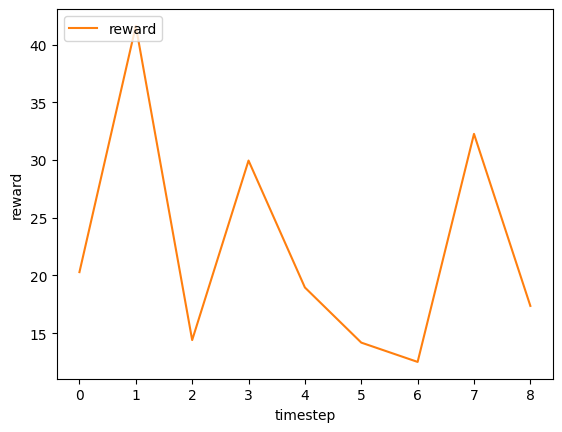

In [64]:
# let's visualize the transition of reward
def visualize_interaction_on_environment(env, agent):
    obs, info = env.reset()
    done = False
    reward_list = []

    while not done:
        action = agent.sample_action_online(obs)
        obs, reward, done, truncated, info = env.step(action)
        reward_list.append(reward)

    # plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(reward_list[:-1], label='reward', color='tab:orange')
    ax1.set_xlabel('timestep')
    ax1.set_ylabel('reward')
    ax1.legend(loc='upper left')
    plt.show()
    
visualize_interaction_on_environment(env, agent)

## 1. Standardized Environment

We provide standardize recommender environment

In [65]:
env = SyntheticEnv(random_state=12345)

## 2. Customize Environmental Configuration
Now, we customize the recommender simulation environment.

We have the following environmental configurations:
- `StateTransition`: State transition of the synthetic simulation.
- `RewardFunction`: Reward function of the synthetic simulation.
- `state_dim`: Dimensions of state.
- `action_type`: action type (i.e., continuous / discrete).
- `n_actions`: Number of actions. Applicable only when reward_type is "discrete".
- `action_context_dim`: Dimensions of the action context.
- `action_context`: Feature vectors that characterizes each action.
- `reward_type`: Reward type (i.e., continuous / binary).
- `reward_std`: Standard deviation of the reward distribution. Applicable only when reward_type is "continuous".
- `obs_std`: Standard deviation of the observation distribution.
- `step_per_episode`: Number of timesteps in an episode.
- `random_state` : Random state

#### Case 1. Customizing the Basic Setup

[7.84052775 6.99229841 0.80668114 8.10591702 6.98300775 0.32457369
 3.72281456 2.66895494 5.44084695 2.32127164]
[6.30859088 2.75252713 9.09817893 4.65508831 2.84558277 9.10932956
 3.29218837 3.63564811 0.41212852 1.84721391]
[1.31567127 3.21448272 2.3238268  7.30744709 0.6270887  6.31720953
 4.52720927 4.23570078 6.06291125 8.34149576]
[2.13932106 9.95060016 8.19325317 5.41193563 5.30929063 1.06446678
 6.1683361  3.0176741  5.89253387 4.53506736]
[8.81432721 0.34099782 8.97653064 3.20021384 3.21059945 8.84102647
 5.05929697 0.78427297 2.0229056  7.29300214]
[0.40219282 9.09923924 4.64935801 0.21042997 4.95673831 0.85430738
 3.24871435 1.90206233 4.64876063 4.95246439]
[1.59664217 5.27538959 9.60190274 5.54450313 4.77025932 0.28375387
 3.19603063 8.76683952 9.32431733 6.65641446]
[4.78698077 0.26134117 0.50338795 8.69704781 8.34137802 2.06618076
 9.97974888 0.97602554 5.39040075 6.25150312]
[4.84373964 6.92756282 3.80754398 6.70926951 7.76109681 1.04752555
 9.45199834 2.26176572 4.3822

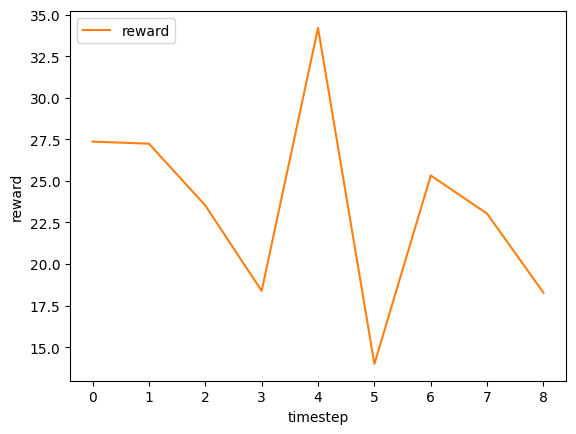

In [66]:
env = SyntheticEnv(
        StateTransition = StateTransition,
        RewardFunction = RewardFunction,
        state_dim = 5,
        n_actions = 10,
        action_context_dim = 10,
        action_context = None,
        reward_type = "continuous",  # "binary"
        reward_std = 0.0,
        obs_std = 0.0,
        step_per_episode = 10,
        random_state = 12345,
)
visualize_interaction_on_environment(env, agent)

#### Case 2. Defining the action_context

In [67]:
# we use the following items for recommendation
action_context = 

SyntaxError: invalid syntax (729911845.py, line 2)

In [ ]:
# we assume that the following 100 users 
user_features = np.sign(random_.normal(size=(100, 5))).astype(int)
user_names, feature_names = [f"user{i+1}" for i in range(100)], [f"feature{i+1}" for i in range(5)]
user_df = pd.DataFrame(user_features, columns=feature_names, index=user_names)
user_df

,feature1,feature2,feature3,feature4,feature5
user1,-1,-1,-1,1,1
user2,-1,-1,1,1,-1
user3,-1,-1,1,1,-1
user4,1,1,1,1,1
user5,-1,-1,1,1,1
...,...,...,...,...,...
user96,-1,-1,-1,-1,1
user97,1,-1,1,1,-1
user98,1,-1,1,-1,-1
user99,-1,1,-1,1,-1


In [ ]:
# using the above data, we can simulate an recommendation as follows
env = SyntheticEnv(
        UserModel = UserModel,
        n_items = 100,  # we use 100 items
        n_users = 100,  # 100 users exists
        item_feature_dim = 5,  #each item has 5 dimensional features
        user_feature_dim = 5,  #each user has 5 dimensional features
        item_feature_vector = item_features, # use item features defined above
        user_feature_vector = user_features, # use user features defined above
        reward_type = "continuous", #we use continuous reward
        reward_std = 0.0,
        obs_std = 0.0, #not add noise to the observation
        step_per_episode = 10,
        random_state = 12345,
)
visualize_interaction_on_environment(env, agent)

NameError: name 'UserModel' is not defined

#### Case 3. Using Customized UserModel(reward_function)

In [ ]:
from synthetic import BaseUserModel
from synthetic import Action

@dataclass
class UserModel(BaseUserModel):
    reward_type: str = "continuous"  # "binary"
    reward_std: float = 0.0
    item_feature_vector: Optional[np.ndarray] = None,
    random_state: Optional[int] = None

    def __post_init__(self):
        check_scalar(
            self.reward_std,
            name="reward_std",
            target_type=float,
        )

        if self.reward_type not in ["continuous", "binary"]:
            raise ValueError(
                f'reward_type must be either "continuous" or "binary", but {self.reward_type} is given'
            )

        self.random_ = check_random_state(self.random_state)

    def user_preference_dynamics(
        self,
        state: np.ndarray,
        action: Action,
        alpha: float = 1.0,
    )-> np.ndarray:
        
        check_scalar(
            state,
            name="state",
            target_type=np.ndarray,
        )
        check_scalar(
            action,
            name="action",
            target_type=Action,
        )

        state = (state + alpha * state @ self.item_feature_vector[action] * self.item_feature_vector[action])
        state = state / np.linalg.norm(state, ord=2)
        return state

    def reward_function(
        self,
        state: np.ndarray,
        action: Action,
    )-> float:
        reward = self.cos_similar_function(state, action)

        if self.reward_type is "continuous":
            reward = reward + self.random_.normal(loc=0.0, scale=self.reward_std)

        return reward

    def cos_similar_function(
        self,
        state: np.ndarray,
        action: Action,
    )-> float:
        inner = state @ self.item_feature_vector[action]
        reward = inner / (np.linalg.norm(state, ord=2) * np.linalg.norm(self.item_feature_vector[action], ord=2))

        return reward

In [ ]:
# setup environment
env = SyntheticEnv(
    UserModel = UserModel,
    reward_type = "continuous",
    random_state=12345
)
visualize_interaction_on_environment(env, agent)


#### Case 4. Using Customized UserModel(user_preference_dynamics and reward_function)

In [ ]:
from synthetic import BaseUserModel
from synthetic import Action

@dataclass
class UserModel(BaseUserModel):
    reward_type: str = "continuous"  # "binary"
    reward_std: float = 0.0
    item_feature_vector: Optional[np.ndarray] = None,
    random_state: Optional[int] = None

    def __post_init__(self):
        check_scalar(
            self.reward_std,
            name="reward_std",
            target_type=float,
        )

        if self.reward_type not in ["continuous", "binary"]:
            raise ValueError(
                f'reward_type must be either "continuous" or "binary", but {self.reward_type} is given'
            )

        self.random_ = check_random_state(self.random_state)

    def user_preference_dynamics(
        self,
        state: np.ndarray,
        action: Action,
        alpha: float = 1.0,
    )-> np.ndarray:
        
        check_scalar(
            state,
            name="state",
            target_type=np.ndarray,
        )
        check_scalar(
            action,
            name="action",
            target_type=Action,
        )

        if self.reward == 1:
            state = (state + alpha * state @ self.item_feature_vector[action] * self.item_feature_vector[action])
            state = state / np.linalg.norm(state, ord=2)
            
        return state

    def reward_function(
        self,
        state: np.ndarray,
        action: Action,
    )-> float:
        self.reward = self.random_.binomial(n=1, p=self.sigmoid(self.cos_similar_function(state, action)))

        if self.reward_type is "continuous":
            reward = reward + self.random_.normal(loc=0.0, scale=self.reward_std)

        return self.reward

    def cos_similar_function(
        self,
        state: np.ndarray,
        action: Action,
    )-> float:
        inner = state @ self.item_feature_vector[action]
        reward = inner / (np.linalg.norm(state, ord=2) * np.linalg.norm(self.item_feature_vector[action], ord=2))

        return reward
    
    def sigmoid(self, x: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    # Sigmoid function
        return 1 / (1 + np.exp(-x))

In [ ]:
# setup environment
env = SyntheticEnv(
    UserModel = UserModel,
    reward_type = "binary",
    random_state=12345
)
visualize_interaction_on_environment(env, agent)


## 3. Customize Bidding Setup in RTB Env
Here, we describe how the decision makers can customize their own RTB environment.  
Specifically, they can setup their own action space and bid price calculation rules by defining the following modules.
- `reward_predictor` in Bidder class  
    We use predicted rewards to calculate the bid price.  
        bid price = adjust rate * predicted reward ( * constant)
    If None, we use the ground-truth reward instead of the predicted reward.  

- `scaler` in Bidder class
    Scaler defines constant in the bid price calculation.  
        bid price = adjust rate * predicted reward ( * constant)
        constant = scaler * standard_bid_price
    where standard_bid_price indicates the average of standard_bid_price  
    (bid price which has approximately 50% impression probability) over all ads.

- `action_space` for agent  
    We transform continual adjust rate space $[0, \infty)$ into agent action space $[0.1, 10]$.  
    Both discrete and continuous actions are acceptable.  
    (We can tune multiplication of adjust rate using scaler.)
    
The arguments are given as follows:
- `original_env`: Original RTB Environment.
- `reward_predictor`: A machine learning model to predict the reward to determine the bidding price.
- `scaler`: Scaling factor (constant value) used for bid price determination. (`None` for the auto-fitting)
- `action_min`: Minimum value of adjust rate.
- `action_max`: Maximum value of adjust rate.
- `action_type`: Action type of the RL agent, which should either be "discrete" or "continuous".
- `n_actions`: Number of "discrete" actions.
- `action_meaning`: Mapping function of agent action index to the actual "discrete" action to take.

In [ ]:
# initialize environment
env = SyntheticEnv(random_state=random_state)

#### Case 1. Defining Continuous Action Space

In [ ]:
# let's customize the continuous action space
env = SyntheticEnv(
    original_env=env,
    action_type="continuous",
)

In [ ]:
# define a random agent
agent = DiscreteEpsilonGreedyHead(
      base_policy = DiscreteRandomPolicy(),
      name = 'random',
      n_actions = env.n_actions,
      epsilon = 1. ,
      random_state = random_state, 
)

In [ ]:
print(custom_env.action_space)


In [ ]:
# another example
custom_env = SyntheticEnv(
    original_env=env,
    action_min=0.1,
    action_max=0.5,
    action_type="continuous",
)

In [ ]:
print(custom_env.action_space)

#### Case 2. Defining Discrete Action Space

In [ ]:
# let's customize the environment and discretize the action space
custom_env = SyntheticEnv(
    random_state=random_state,
    action_type="discrete",
)

In [ ]:
print(custom_env.action_space)


Discrete(100)


AttributeError: 'SyntheticEnv' object has no attribute 'action_meaning'

In [ ]:
# another example
custom_env = SyntheticEnv(
    original_env=env,
    action_type="discrete",
    n_actions=5,
    action_meaning=np.arange(1, 6)
)

In [ ]:
print(custom_env.action_space)
print(custom_env.action_meaning)

## Reference
- Sarah Dean, Jamie Morgenstern. \
"Preference Dynamics Under Personalized Recommendations.", 2022.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- David Rohde, Stephen Bonner, Travis Dunlop, Flavian Vasile, Alexandros Karatzoglou. \
"RecoGym: A Reinforcement Learning Environment for the Problem of Product Recommendation in Online Advertising." 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.